<a href="https://colab.research.google.com/github/atmiktumane/Aroe-flight-fare-prediction/blob/main/Vgg16_acc_81_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
! pip install -q kaggle

In [7]:
 ! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"atmiktumane","key":"84687d7bfbcca2a6707efd907021c07e"}'}

In [9]:
! cp kaggle.json ~/.kaggle/

In [10]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [11]:
! kaggle datasets list

ref                                                      title                                     size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------  ---------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide     Covid Cases and Deaths WorldWide           8KB  2023-02-01 12:22:51          10821        355  1.0              
naveenkumar20bps1137/walmart-sales-analysis              WALMART SALES ANALYSIS                   119KB  2023-03-03 18:02:11           1245         40  0.9411765        
datascientistanna/customers-dataset                      Shop Customer Data                        23KB  2023-02-07 18:42:21           9220        213  1.0              
ulrikthygepedersen/co2-emissions-by-country              CO2 Emissions                            114KB  2023-02-28 12:39:49            743         26

In [12]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:46<00:00, 20.7MB/s]
100% 2.29G/2.29G [01:46<00:00, 23.1MB/s]


In [13]:
! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [14]:
!pwd

/content


In [42]:
import tensorflow
import pandas as pd
import numpy as np
import os
import keras
from tensorflow.keras.applications import DenseNet169, DenseNet121, VGG16
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt

In [43]:
base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
base_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [44]:
training_dir='./chest_xray/train/'
validation_dir='./chest_xray/val/'
test_dir='./chest_xray/test/'

In [45]:
test_ds = image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=16,
    image_size=(224, 224),
    )

Found 624 files belonging to 2 classes.


In [46]:
train_ds = image_dataset_from_directory(
    directory=training_dir,
    shuffle=True,
    labels='inferred',
    label_mode='binary',
    batch_size=16,
    image_size=(224, 224),
    )

Found 5216 files belonging to 2 classes.


In [47]:
validation_ds = image_dataset_from_directory(
    directory=validation_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=16,
    image_size=(224, 224),
    )

Found 16 files belonging to 2 classes.


In [48]:
data_augmentation = tensorflow.keras.Sequential([
  tensorflow.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
  tensorflow.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [49]:
test_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [50]:
x=base_model.output

x= data_augmentation(x)
x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.6)(x)
# x= Dense(1024,activation='relu')(x) 
x= Dense(512,kernel_regularizer=regularizers.l2(0.0001), activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.6)(x)

preds=Dense(2,activation='softmax')(x)

In [51]:
model=Model(inputs=base_model.input,outputs=preds)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [52]:
# for layer in model.layers[:-8]:
#     layer.trainable=False

# for layer in model.layers[-8:]:
#     layer.trainable=True

In [53]:
base_model.trainable = False

In [54]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-4),loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [55]:
len(model.trainable_variables)

8

In [56]:
initial_epochs = 20

In [57]:
history=model.fit(x=train_ds,
                           validation_data=validation_ds,
                           epochs=initial_epochs,
                           verbose=1)

Epoch 1/20


326/326 [==============================] - 45s 121ms/step - loss: 0.8398 - accuracy: 0.7308 - val_loss: 0.1503 - val_accuracy: 1.0000
Epoch 2/20
326/326 [==============================] - 42s 124ms/step - loss: 0.5317 - accuracy: 0.8349 - val_loss: 0.1462 - val_accuracy: 1.0000
Epoch 3/20
326/326 [==============================] - 40s 121ms/step - loss: 0.4239 - accuracy: 0.8704 - val_loss: 0.2094 - val_accuracy: 0.9375
Epoch 4/20
326/326 [==============================] - 40s 122ms/step - loss: 0.3552 - accuracy: 0.8940 - val_loss: 0.2011 - val_accuracy: 1.0000
Epoch 5/20
326/326 [==============================] - 40s 121ms/step - loss: 0.3517 - accuracy: 0.8940 - val_loss: 0.2022 - val_accuracy: 1.0000
Epoch 6/20
326/326 [==============================] - 40s 121ms/step - loss: 0.2928 - accuracy: 0.9155 - val_loss: 0.2338 - val_accuracy: 0.9375
Epoch 7/20
326/326 [==============================] - 41s 124ms/step - loss: 0.2920 - accuracy: 0.9145 - val_loss: 0.2098 - val_accuracy: 0.9

In [58]:
score = model.evaluate(test_ds, verbose = 1) 

39/39 [==============================] - 5s 105ms/step - loss: 0.5795 - accuracy: 0.8157


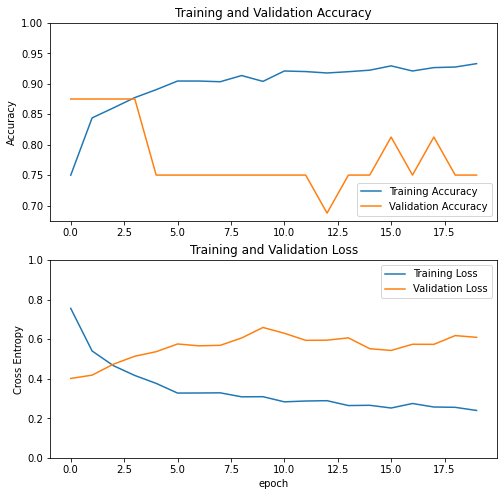

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
base_model.trainable = True

In [34]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 42

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  86


In [35]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-5),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [36]:
len(model.trainable_variables)

50

In [37]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_ds)

Epoch 20/40


326/326 [==============================] - 63s 147ms/step - loss: 0.3790 - accuracy: 0.8790 - val_loss: 0.5381 - val_accuracy: 0.8750
Epoch 21/40
326/326 [==============================] - 48s 145ms/step - loss: 0.2701 - accuracy: 0.9199 - val_loss: 0.4926 - val_accuracy: 0.8750
Epoch 22/40
326/326 [==============================] - 47s 144ms/step - loss: 0.2520 - accuracy: 0.9256 - val_loss: 0.4197 - val_accuracy: 0.8750
Epoch 23/40
326/326 [==============================] - 48s 142ms/step - loss: 0.2139 - accuracy: 0.9450 - val_loss: 0.3515 - val_accuracy: 0.9375
Epoch 24/40
326/326 [==============================] - 48s 145ms/step - loss: 0.1973 - accuracy: 0.9490 - val_loss: 0.2867 - val_accuracy: 0.9375
Epoch 25/40
326/326 [==============================] - 48s 144ms/step - loss: 0.1910 - accuracy: 0.9528 - val_loss: 0.2871 - val_accuracy: 0.9375
Epoch 26/40
326/326 [==============================] - 47s 141ms/step - loss: 0.1740 - accuracy: 0.9590 - val_loss: 0.2776 - val_accurac

In [38]:
score = model.evaluate(test_ds, verbose = 1) 

39/39 [==============================] - 3s 57ms/step - loss: 0.9113 - accuracy: 0.8109


In [39]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

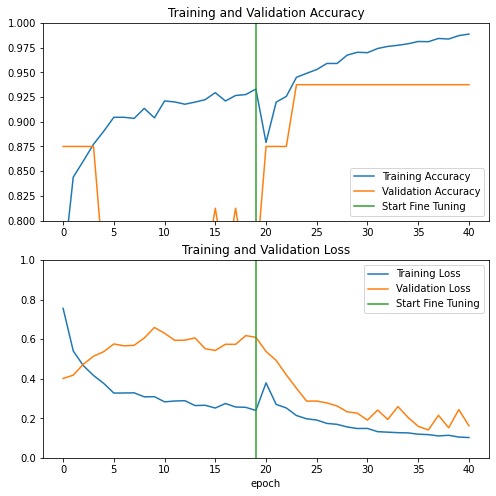

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [41]:
model.save('/')